# Load necessary libraries

In [1]:
import json
import re
import numpy as np
import pandas as pd
import scipy.spatial.distance as sp_dist
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict
from spacy.lang.en import English
from scipy.special import softmax
from mechanisms.detectors.presidio_detector import PresidioDetector

# Define parameters

In [2]:
TAB_FILE_PATH = "echr_train.json"
WORD_EMBEDDING_PATH = "glove.840B.300d.txt"
TOP_K = 20
EPSILON = 1
P = 2

# Load dataset

In [3]:
def normalize_distances(distances):
    """Normalize the given distances"""
    distance_range = max(distances) - min(distances)
    # Check if distance_range is zero (i.e., all distances are the same)
    if distance_range == 0:
        # If so, return an array of zeros (or some other default value)
        return [0 for _ in distances]
    min_distance = min(distances)
    return [-(dist - min_distance) / distance_range for dist in distances]

In [4]:
def has_header(file):
    """Check if the embeddings file has a header"""
    return len(file.readline().split()) == 2

In [5]:
def read_json_file(file_path):
    """Read a JSON file and return the data"""
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

In [6]:
def extract_text_values(data):
    """Extract 'text' values from data"""
    return [item["text"] for item in data if "text" in item]

In [7]:
def build_vocab_from_dataset(df):
    """Build vocabulary from dataset"""
    tokenizer = English()
    vocab = Counter()
    for text in df["sentence"]:
        tokenized_text = [
            token.text
            for token in tokenizer(text)
            if (token.is_alpha or token.is_digit)
        ]
        vocab.update(tokenized_text)
    return vocab

In [8]:
def parse_embedding_row(row):
    """Parse a row in the general_embeddings file"""
    content = row.rstrip().split(" ")
    return content[0], [float(i) for i in content[1:]]

In [9]:
def process_word_embedding(
    word,
    embedding,
    vocab,
    word_to_id,
    general_word_embeddings,
):
    """Process a single word embedding"""
    if word in vocab and word not in word_to_id and not re.match(r"^\d+$", word):
        word_to_id[word] = len(general_word_embeddings)
        general_word_embeddings.append(embedding)

In [10]:
def process_word_embeddings(vocab):
    """Process word general_embeddings and return arrays and dictionaries for words in the vocabulary"""
    word_to_id = {}
    general_word_embeddings = []
    num_lines = sum(1 for _ in open(WORD_EMBEDDING_PATH, encoding="utf-8"))

    with open(WORD_EMBEDDING_PATH, encoding="utf-8") as file:
        if not has_header(file):
            file.seek(0)
        num_lines = sum(1 for _ in file)
        file.seek(0)

        for row in tqdm(file, total=num_lines - 1):
            word, embedding = parse_embedding_row(row)
            process_word_embedding(
                word,
                embedding,
                vocab,
                word_to_id,
                general_word_embeddings,
            )

    return (np.asarray(general_word_embeddings), word_to_id)

In [11]:
detector = PresidioDetector()
data = read_json_file(TAB_FILE_PATH)
text_values = extract_text_values(data)
tab_df = pd.DataFrame(text_values, columns=["sentence"])
vocab = build_vocab_from_dataset(tab_df)
words = [key for key, _ in vocab.most_common()]
sensitive_words = detector.detect(vocab)
processed_data = process_word_embeddings(vocab)
(general_embeddings, word_to_id) = processed_data
id_to_word = {v: k for k, v in word_to_id.items()}

2196017it [00:54, 40650.87it/s]                                                 


# Analysis

In [12]:
print(general_embeddings[word_to_id["Denmark"]]) # get GloVe embedding of a word

[ 1.2216e-01  2.7970e-01  1.8672e-01  1.0573e-01 -4.2233e-02 -6.0927e-01
  6.7466e-01 -2.6028e-01  6.8514e-02  1.8293e+00 -8.2946e-01  2.1600e-01
  1.7139e-02  2.9856e-01  4.5916e-01  4.1449e-01 -1.2215e-01  2.7371e-01
  6.6174e-01  2.0479e-01  8.1152e-01  7.1084e-01 -2.2744e-01  2.5041e-02
 -3.8991e-01 -4.8706e-01  2.4147e-01 -6.7888e-01 -3.6895e-02  4.9789e-01
 -2.6198e-01  1.9797e-01 -1.2565e-01 -6.2551e-02  4.8121e-01  7.5438e-02
  1.8518e-01 -5.6226e-01  1.1511e-01 -2.3666e-02  1.3574e-01 -8.6566e-02
 -5.3859e-02  7.5830e-02 -1.6342e-01 -2.8149e-01  1.1708e-01 -6.2137e-01
 -2.0770e-01 -2.2252e-01  1.2375e-01  4.8703e-01 -2.2987e-02 -5.5000e-01
  3.5051e-01 -7.8361e-01  4.3651e-02 -4.7431e-01  8.3053e-01 -1.2642e-01
 -6.8961e-02  3.1709e-01  5.8703e-01  2.7367e-01 -7.0615e-01  4.7108e-01
  5.2865e-01  2.9753e-01  2.8927e-01 -5.1843e-01 -4.9704e-01  2.0183e-01
  2.2417e-01  1.0386e-01  4.1394e-01  5.3294e-04 -2.3545e-01  1.2492e-01
  3.8002e-01 -1.0052e-01  2.4498e-01 -1.7738e-01  3

In [13]:
distance = sp_dist.cdist(
    general_embeddings[word_to_id["Denmark"]].reshape(1, -1),
    general_embeddings[word_to_id["Norway"]].reshape(1, -1),
    metric="minkowski",
    p=P,
)[0]

print(distance) # get distance between Denmark and Norway

[4.32847811]


# Calculate sensitivity

In [14]:
max_distance_dict = defaultdict(float)

for word in sensitive_words:
    if word in word_to_id and word not in max_distance_dict:
        similar_indices = sp_dist.cdist(
            general_embeddings[word_to_id[word]].reshape(1, -1),
            general_embeddings,
            metric="minkowski",
            p=P,
        )[0].argsort()[:TOP_K]
        max_distance_index = similar_indices[-1]
        max_distance = sp_dist.cdist(
            general_embeddings[word_to_id[word]].reshape(1, -1),
            general_embeddings[max_distance_index].reshape(1, -1),
            metric="minkowski",
            p=P,
        )
        max_distance_dict[word] = max_distance  

In [15]:
max_word, sensitivity = max(max_distance_dict.items(), key=lambda item: item[1])

In [16]:
print(max_word)
print(sensitivity)

materiae
[[12.02772707]]


In [17]:
# find substitute word for 'Denmark' based on exponential mechanism
word = "Denmark"
distances = sp_dist.cdist(
    general_embeddings[word_to_id[word]].reshape(1, -1),
    general_embeddings,
    metric="minkowski",
    p=P,
)[0]
sim_matrix = -distances
prob_matrix = softmax(1 * sim_matrix / (2 * sensitivity))[0]
substitute_idx = np.random.choice(len(prob_matrix), 1, p=prob_matrix)
print(id_to_word[substitute_idx[0]])

sceptical


In [18]:
prob_matrix[word_to_id["Norway"]] # Check the probability of 'Norway' being chosen as a replacement word for 'Denmark' 

5.618759557284633e-05

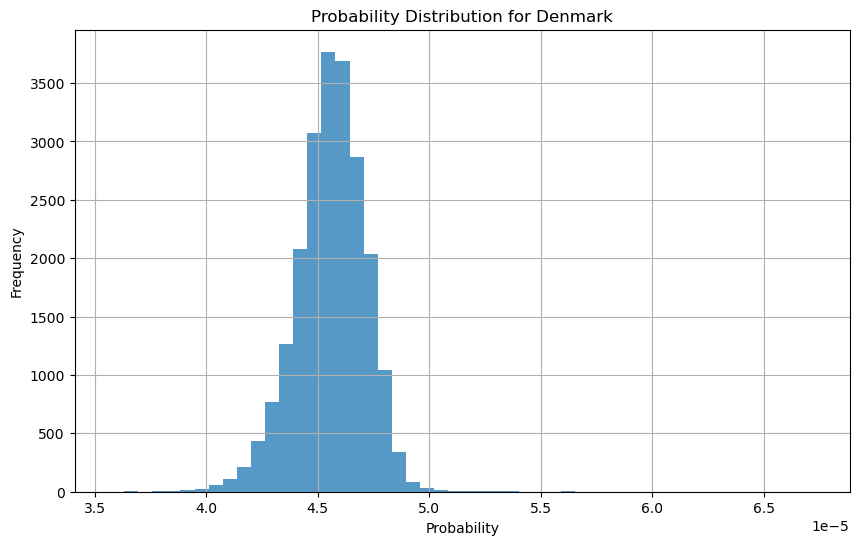

In [19]:
# Plotting the probability distribution for Denmark
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(prob_matrix, bins=50, alpha=0.75)  # Adjust the number of bins as needed
plt.title(f"Probability Distribution for {word}")
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()